# ⚙️Build and Analyse Dynamic Bayesian

### Util functions

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.inference import DBNInference
from pgmpy.estimators import MaximumLikelihoodEstimator
import pandas as pd
import glob
import os
import ast 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
columns = ['NDVI','Temperature','Humidity','Rain','SurfacePressure',
           'CloudCover', 'WindSpeed','Migrating' ,'Region']

nodes= [
    ('SurfacePressure', 0),
    ('Rain', 0),
    ('Temperature', 0),
    ('WindSpeed', 0),
    ('CloudCover', 0),
    ('Humidity', 0),
    ('Migrating', 0),
    ('NDVI', 0),
    ('SurfacePressure', 1),
    ('Rain', 1),
    ('Temperature', 1),
    ('WindSpeed', 1),
    ('CloudCover', 1),
    ('Humidity', 1),
    ('Migrating', 1),
    ('NDVI', 1)
]

### 🔹Load data, Prepare train-set

In [3]:
input = pd.read_csv(os.path.join('data','DBN_input_data.csv'),sep=';')
if 'Unnamed: 0' in input.columns:
    input = input.drop(['Unnamed: 0'],axis=1)
print(input.shape)
display(input.head())

(28, 1)


,Timeseries
0,"[0, 0, 1, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 0, 0, ..."
1,"[0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, ..."
2,"[0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, ..."
3,"[0, 0, 1, 1, 0, 1, 1, 1, 2, 0, 0, 1, 1, 1, 1, ..."
4,"[0, 1, 1, 0, 1, 1, 1, 0, 2, 0, 0, 1, 1, 0, 1, ..."


In [4]:
input_list = []
test_data_list = []
for ind,row in input.iterrows():
    record = ast.literal_eval(row['Timeseries'])
    if len(record)//len(columns) > 18:
        input_list.append(record)
    else:
        test_data_list.append(record)
        
print(len(input_list))
print(len(test_data_list))

17
11


In [5]:
min_length = min(len(inner_list) for inner_list in input_list)
cut_lists = [inner_list[:min_length] for inner_list in input_list]

time_range = min_length//len(columns)
colnames = []
for t in range(time_range):
     extended_list = []
     for col in columns:
         extended_list.append((col,t))
     colnames.extend(extended_list)

data = pd.DataFrame(cut_lists, columns=colnames)
display(data.head())
print(data.shape)

,"(NDVI, 0)","(Temperature, 0)","(Humidity, 0)","(Rain, 0)","(SurfacePressure, 0)","(CloudCover, 0)","(WindSpeed, 0)","(Migrating, 0)","(Region, 0)","(NDVI, 1)",...,"(Region, 17)","(NDVI, 18)","(Temperature, 18)","(Humidity, 18)","(Rain, 18)","(SurfacePressure, 18)","(CloudCover, 18)","(WindSpeed, 18)","(Migrating, 18)","(Region, 18)"
0,0,0,1,0,1,0,1,0,2,0,...,4,1,0,0,0,0,0,0,0,4
1,0,0,1,1,0,1,1,1,2,0,...,4,1,0,1,1,0,1,0,0,2
2,0,1,1,0,1,1,1,0,2,0,...,4,1,1,0,0,0,0,1,1,4
3,0,2,0,0,0,0,0,0,4,0,...,4,1,0,0,0,0,0,0,0,4
4,0,0,1,1,1,1,0,1,2,0,...,4,1,0,0,1,0,0,0,0,4


(17, 171)


### 🔹Build Dynamic Bayesian Network

💡**This is just a proposed structure of the Bayesian Netwrok**. In this Bayesian network, each variable represents a key meteorological or environmental concept, and their relationships are closely intertwined, influencing one another in complex ways, therefore, the network's design can be adapted and refined to capture different facets of these interactions.

1. **SurfacePressure -> Temperature**:<br/>It is hypothesized that changes in surface pressure may influence temperature patterns in the atmosphere. This could be due to the relationship between atmospheric pressure and temperature, where high pressure systems tend to be associated with warmer temperatures and low pressure systems with cooler temperatures [Read more](http://ww2010.atmos.uiuc.edu/(Gh)/guides/mtr/fw/prs/prstmp.rxml) [Read more](https://unacademy.com/content/nda/study-material/geography/temperature-and-pressure-atmospheric-pressure/#:~:text=The%20relationship%20between%20the%20atmospheric,pressure%20of%20that%20place%20rises.) <br/>
2. **Rain -> Temperature**: Rainfall can have a significant impact on surface temperatures through various mechanisms such as evaporative cooling, cloud cover, and albedo change [Read more](https://journals.ametsoc.org/view/journals/apme/8/1/1520-0450_1969_008_0015_iorota_2_0_co_2.xml)<br/>

3. **Temperature -> CloudCover**: Temperature and cloud cover are closely related meteorological variables. Warmer temperatures can lead to increased evaporation and moisture in the atmosphere, which in turn can lead to the formation of clouds. [Read More](https://euanmearns.com/do-clouds-control-temperature-or-does-temperature-control-clouds/)

4. **WindSpeed -> CloudCover**: Wind speed can affect cloud cover through its role in atmospheric circulation patterns and moisture transport. Higher wind speeds can enhance the mixing of air masses with different moisture contents, potentially leading to the formation of clouds or influencing their distribution [Read more](https://www.noaa.gov/jetstream)<br/>

5. **CloudCover -> Humidity**: Cloud cover is a major determinant of atmospheric humidity. Clouds can both contribute to and reflect atmospheric moisture, influencing humidity levels in the atmosphere. Additionally, cloud formation is closely linked to the availability of moisture in the atmosphere. Source: American Geophysical Union - The Role of Clouds in Atmospheric Humidity<br/>

6. **All climate variables -> Migrating**: [Read more](https://www.sciencedirect.com/science/article/abs/pii/0003347268900468) <br/>

7. **NDVI -> Migrating**: The Normalized Difference Vegetation Index (NDVI) is a measure of vegetation greenness or density derived from satellite observations. Changes in NDVI values can indicate variations in vegetation cover and productivity, which in turn can affect the availability of food and habitat for migratory species. For example, high NDVI values may indicate abundant vegetation and suitable habitats for migration. [Read more](https://www.sciencedirect.com/science/article/pii/S1877050915019444#:~:text=NDVI%20employs%20the%20Multi%2DSpectral,of%20the%20remote%20sensed%20data.)


In [6]:
bn_edges = [
    # (('Region',0),('SurfacePressure',0)),
    # (('Region',0),('Temperature',0)),
    # (('Region',0),('WindSpeed',0)),
    # (('Region',0),('Migrating',0)),
    (('SurfacePressure',0),('Temperature',0)),
    (('SurfacePressure',0),('Migrating',0)),
    (('Rain',0),('Temperature',0)),
    (('Rain',0),('Migrating',0)),
    (('Temperature',0), ('CloudCover',0)),
    (('Temperature',0), ('Migrating',0)),
    (('WindSpeed',0), ('CloudCover',0)),
    (('WindSpeed',0), ('Migrating',0)),
    (('Humidity',0), ('Migrating',0)),
    (('CloudCover', 0), ('Humidity', 0)),
    (('CloudCover', 0), ('Migrating', 0)),
    (('NDVI', 0), ('Migrating', 0)),
    #(('Region',0),('Region',1)),
    (('Temperature',0),('Temperature',1)),
    (('Rain',0),('Rain',1)),
    (('WindSpeed',0), ('WindSpeed',1)),
    (('Humidity',0),('Humidity',1)),
    (('CloudCover',0),('CloudCover',1)),
    (('SurfacePressure',0),('SurfacePressure',1)),
    (('NDVI', 0), ('NDVI', 1)),
    (('Migrating',0), ('Migrating',1))
]

dbn = DBN()
dbn.add_edges_from(bn_edges) #Give predefined BN structure

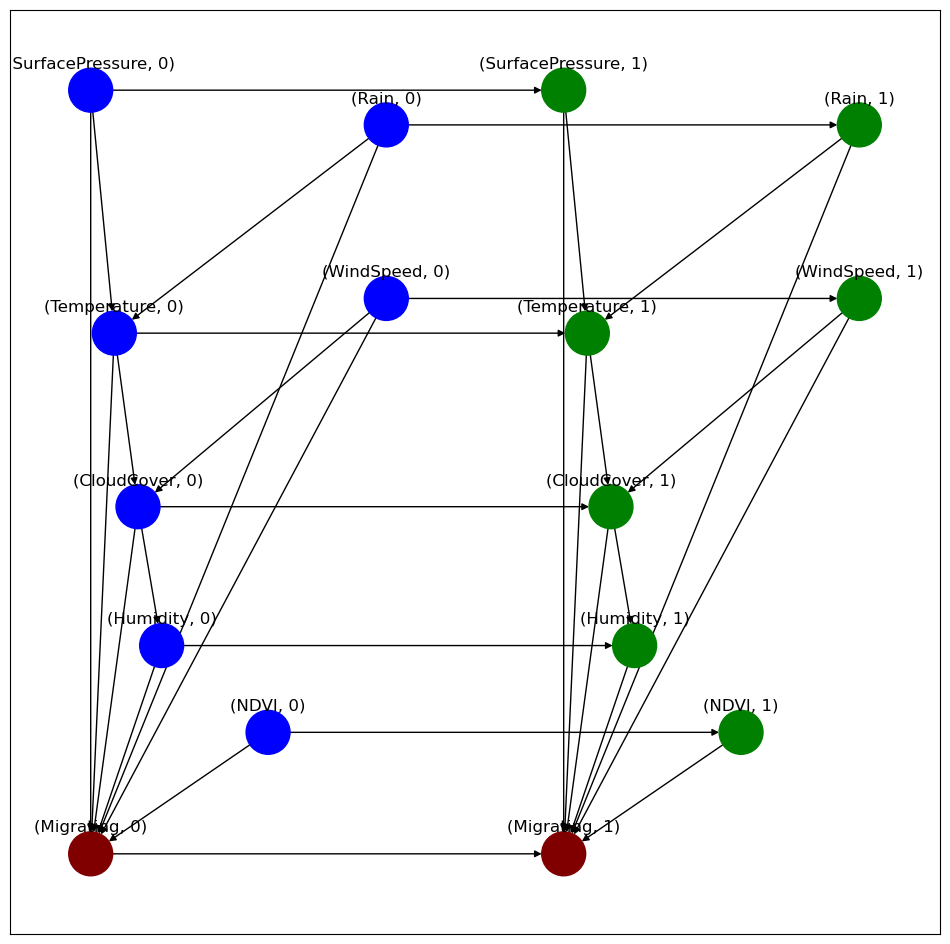

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
pos = {
    ('SurfacePressure', 0): [0, 0.2],
    ('Rain', 0): [2.5, 0],
    ('Temperature', 0): [0.2, -1.2],
    ('WindSpeed', 0): [2.5, -1],
    ('CloudCover', 0): [0.4, -2.2],
    ('Humidity', 0): [0.6, -3],
    ('Migrating', 0): [0, -4.2],
    ('NDVI', 0): [1.5, -3.5],
    ('SurfacePressure', 1): [4, 0.2],
    ('Rain', 1): [6.5, 0],
    ('Temperature', 1): [4.2, -1.2],
    ('WindSpeed', 1): [6.5, -1],
    ('CloudCover', 1): [4.4, -2.2],
    ('Humidity', 1): [4.6, -3],
    ('Migrating', 1): [4, -4.2],
    ('NDVI', 1): [5.5, -3.5]
}

node_colors = {('SurfacePressure', 0): 'blue', ('Rain', 0): 'blue', ('Temperature', 0): 'blue',
               ('WindSpeed', 0): 'blue', ('CloudCover', 0): 'blue', ('Humidity', 0): 'blue',
               ('Migrating', 0): 'maroon', ('NDVI', 0): 'blue',
               ('SurfacePressure', 1): 'green', ('Rain', 1): 'green', ('Temperature', 1): 'green',
               ('WindSpeed', 1): 'green', ('CloudCover', 1): 'green', ('Humidity', 1): 'green',
               ('Migrating', 1): 'maroon', ('NDVI', 1): 'green'}
nx.draw_networkx(dbn, pos=pos, node_color=[node_colors[node] for node in dbn.nodes()], with_labels=False,node_size=1000)
node_labels = nx.draw_networkx_labels(dbn, pos={node: (x, y + 0.15) for node, (x, y) in pos.items()})

fig.savefig('ProposedDBN')

In [8]:
display(data.head())
dbn.fit(data)    #Fit data
print('Data fitted')

,"(NDVI, 0)","(Temperature, 0)","(Humidity, 0)","(Rain, 0)","(SurfacePressure, 0)","(CloudCover, 0)","(WindSpeed, 0)","(Migrating, 0)","(Region, 0)","(NDVI, 1)",...,"(Region, 17)","(NDVI, 18)","(Temperature, 18)","(Humidity, 18)","(Rain, 18)","(SurfacePressure, 18)","(CloudCover, 18)","(WindSpeed, 18)","(Migrating, 18)","(Region, 18)"
0,0,0,1,0,1,0,1,0,2,0,...,4,1,0,0,0,0,0,0,0,4
1,0,0,1,1,0,1,1,1,2,0,...,4,1,0,1,1,0,1,0,0,2
2,0,1,1,0,1,1,1,0,2,0,...,4,1,1,0,0,0,0,1,1,4
3,0,2,0,0,0,0,0,0,4,0,...,4,1,0,0,0,0,0,0,0,4
4,0,0,1,1,1,1,0,1,2,0,...,4,1,0,0,1,0,0,0,0,4


Data fitted


#### 🔺Calculate CPD and DiscreteFactor

In [9]:
def get_titles_for_cpds(cpds):
    titles = []
    string_cpds = str(cpds)
    for cpd in string_cpds.split('>,'):
        start_index = cpd.find("P((")
        if '|' in cpd:
            end_index = cpd.find("|")
        else:
            end_index = cpd.find(" at")
        title = cpd[start_index+2:end_index-3]
        titles.append(title)
    return titles

In [10]:
def display_factor_summary(factor, num_values=5):
    print("Variables:")
    for var in factor.variables:
        print(var)
    print("Cardinality:", factor.cardinality)

cpds = dbn.get_cpds()
cpd_titles=get_titles_for_cpds(cpds)
for i in range(len(cpds)):
    print('=================================================================================================')
    print(cpd_titles[i])
    print(cpds[i])
index_of_migrating1 = cpd_titles.index("(Migrating, 1)")
migrating_cpd = cpds[index_of_migrating1]
migrating_cpd.to_csv(os.path.join('data',"Migrating_CPD.csv"))

(Migrating, 0)
+----------------------+-------------------------+-----+-------------------------+-------------------------+
| (CloudCover, 0)      | (CloudCover, 0)(0)      | ... | (CloudCover, 0)(1)      | (CloudCover, 0)(1)      |
+----------------------+-------------------------+-----+-------------------------+-------------------------+
| (Humidity, 0)        | (Humidity, 0)(0)        | ... | (Humidity, 0)(1)        | (Humidity, 0)(1)        |
+----------------------+-------------------------+-----+-------------------------+-------------------------+
| (NDVI, 0)            | (NDVI, 0)(0)            | ... | (NDVI, 0)(1)            | (NDVI, 0)(1)            |
+----------------------+-------------------------+-----+-------------------------+-------------------------+
| (Rain, 0)            | (Rain, 0)(0)            | ... | (Rain, 0)(1)            | (Rain, 0)(1)            |
+----------------------+-------------------------+-----+-------------------------+-------------------------+
| (S

In [11]:
migrating_factor = migrating_cpd.to_factor()
display_factor_summary(migrating_factor)

Variables:
(Migrating, 1)
(CloudCover, 1)
(Humidity, 1)
(Migrating, 0)
(NDVI, 1)
(Rain, 1)
(SurfacePressure, 1)
(Temperature, 1)
(WindSpeed, 1)
Cardinality: [2 2 2 2 2 2 2 3 2]


In [12]:
print(migrating_factor)

+-------------------+--------------------+------------------+-------------------+--------------+--------------+-------------------------+---------------------+-------------------+---------------------------------------------------------------------------------------------------------------------------------------------+
| (Migrating, 1)    | (CloudCover, 1)    | (Humidity, 1)    | (Migrating, 0)    | (NDVI, 1)    | (Rain, 1)    | (SurfacePressure, 1)    | (Temperature, 1)    | (WindSpeed, 1)    |   phi((Migrating, 1),(CloudCover, 1),(Humidity, 1),(Migrating, 0),(NDVI, 1),(Rain, 1),(SurfacePressure, 1),(Temperature, 1),(WindSpeed, 1)) |
+===================+====================+==================+===================+==============+==============+=========================+=====================+===================+=============================================================================================================================================+
| (Migrating, 1)(0) | (CloudCover,

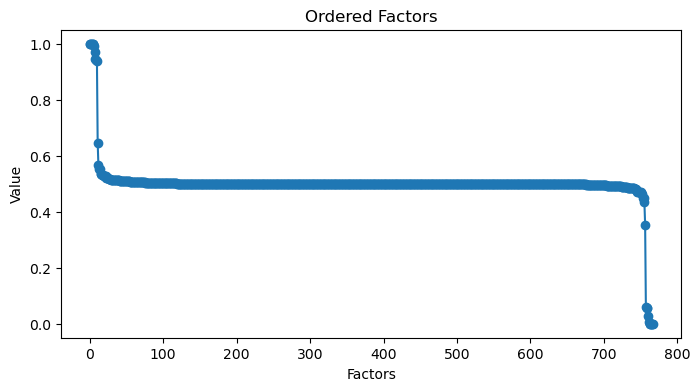

In [13]:
def flatten_np(arr):
    flat_list = []
    for item in arr:
        if isinstance(item, np.ndarray):
            flat_list.extend(flatten_np(item))
        else:
            flat_list.append(item)
    return flat_list

flat_list = flatten_np(list(migrating_factor.values))
flat_list.sort(reverse=True)

# Plot the flattened list
plt.figure(figsize=(8, 4))
plt.plot(flat_list, marker='o', linestyle='-')
plt.xlabel('Factors')
plt.ylabel('Value')
plt.title('Ordered Factors')
plt.show()

With this visualization we can see that (almost all of) the factors learned have around 0.5 value, it suggests that the model's predictions are close to random guessing. A factor close to 0.5 indicates uncertainty or lack of strong correlation between variables, limited predictive power in the Bayesian network

#### 🔺Independencies

💡 In a Bayesian network, the presence of an active trail between two variables indicates a probabilistic dependence between them, rather than independence. An active trail exists between two variables if there is a path between them where the arrows are either all pointing in the direction of the path or all pointing away from the path.

In [14]:
print(f'Analyzing model: {dbn}')
#print(f'The total number of valid independence assertions is {len(dbn.get_independencies().get_assertions())}')
print(f'Local semantics of the current model:\n')
print(dbn.local_independencies(nodes))

Analyzing model: DynamicBayesianNetwork with 16 nodes and 32 edges
Local semantics of the current model:

(0, SurfacePressure ⟂ (Rain, 0), (WindSpeed, 1), (NDVI, 1), (Rain, 1), (WindSpeed, 0), (NDVI, 0))
(0, Rain ⟂ (WindSpeed, 1), (SurfacePressure, 1), (NDVI, 1), (SurfacePressure, 0), (WindSpeed, 0), (NDVI, 0))
(0, Temperature ⟂ (SurfacePressure, 1), (WindSpeed, 1), (NDVI, 1), (Rain, 1), (WindSpeed, 0), (NDVI, 0) | (Rain, 0), (SurfacePressure, 0))
(0, WindSpeed ⟂ (Rain, 0), (Temperature, 0), (NDVI, 1), (NDVI, 0), (SurfacePressure, 1), (Rain, 1), (SurfacePressure, 0), (Temperature, 1))
(0, CloudCover ⟂ (Rain, 0), (NDVI, 1), (NDVI, 0), (SurfacePressure, 1), (WindSpeed, 1), (Rain, 1), (SurfacePressure, 0), (Temperature, 1) | (WindSpeed, 0), (Temperature, 0))
(0, Humidity ⟂ (Rain, 0), (Temperature, 0), (NDVI, 1), (SurfacePressure, 0), (NDVI, 0), (SurfacePressure, 1), (WindSpeed, 1), (Rain, 1), (CloudCover, 1), (WindSpeed, 0), (Temperature, 1) | (CloudCover, 0))
(0, Migrating ⟂ (Humidity, 1

📝 _Examples_: Independence rule visualized ((0, SurfacePressure ⟂ (WindSpeed, 0), (WindSpeed, 1), (NDVI, 0), (Rain, 0), (Rain, 1), (NDVI, 1)))

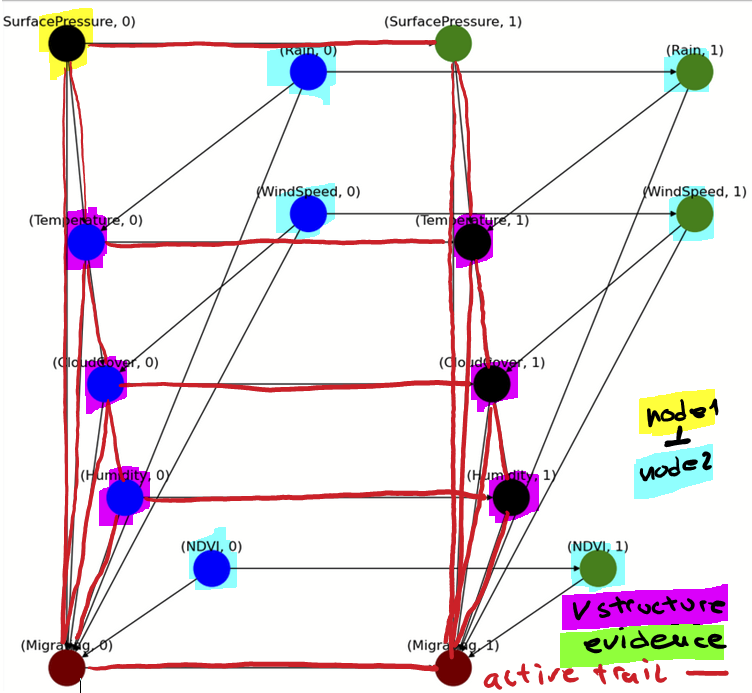

📝 _Examples_: Independence rule visualized (Migrating, 1 ⟂ (Humidity, 0), (Rain, 0), (WindSpeed, 0), (Temperature, 0), (NDVI, 0), (SurfacePressure, 0), (CloudCover, 0) | (CloudCover, 1), (Humidity, 1), (Migrating, 0), (Temperature, 1), (Rain, 1), (NDVI, 1), (WindSpeed, 1), (SurfacePressure, 1))

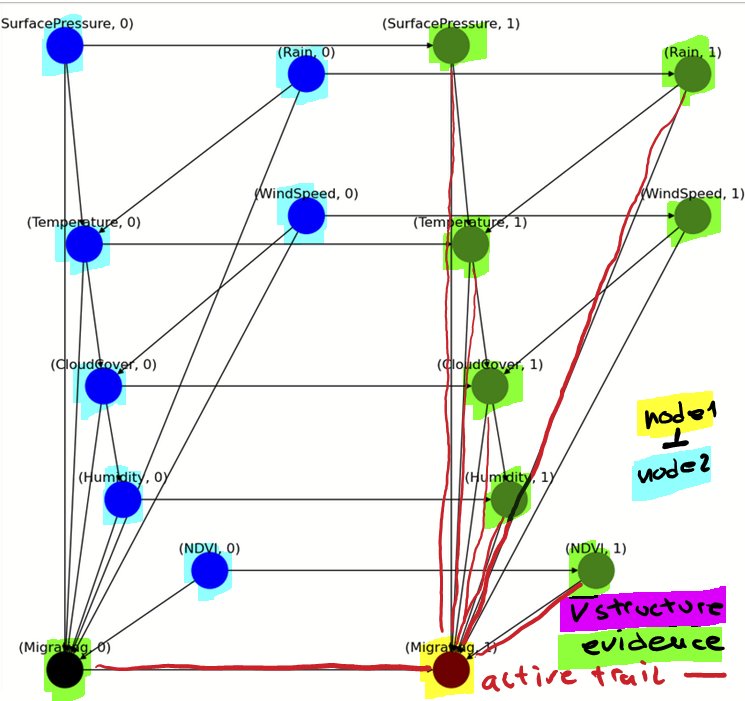

📝 Examples: Independence rule visualized (0, CloudCover ⟂ (Temperature, 1), (Rain, 1), (Rain, 0), (NDVI, 1), (SurfacePressure, 1), (WindSpeed, 1), (NDVI, 0), (SurfacePressure, 0) | (WindSpeed, 0), (Temperature, 0))

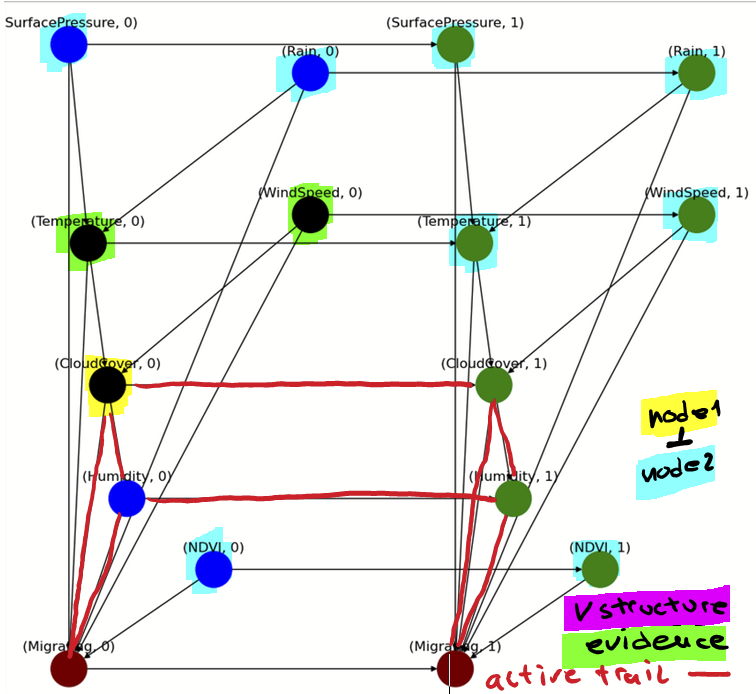

#### 🔺Markov blanket

💡In Bayesian networks, a Markov blanket of a node is the set of nodes that renders the node conditionally independent of all other nodes in the network. In other words, given the Markov blanket of a node, knowledge of the states of all other nodes in the network does not provide any additional information about the node in question. Consists of three sets of nodes: Parents, Children, Parents of children of X

In [15]:
print('Checking Markov blankets\n')
node = ('CloudCover',0)
print(f'The Markov blanket of node {node} is {dbn.get_markov_blanket(node)}')

Checking Markov blankets

The Markov blanket of node ('CloudCover', 0) is [<DynamicNode(CloudCover, 1) at 0x1ccec67b520>, <DynamicNode(Humidity, 0) at 0x1ccec64db20>, <DynamicNode(Migrating, 0) at 0x1ccec64d4f0>, <DynamicNode(NDVI, 0) at 0x1ccec67b040>, <DynamicNode(Rain, 0) at 0x1ccec639ac0>, <DynamicNode(SurfacePressure, 0) at 0x1ccec66eac0>, <DynamicNode(Temperature, 0) at 0x1ccec6397c0>, <DynamicNode(Temperature, 1) at 0x1ccec639730>, <DynamicNode(WindSpeed, 0) at 0x1ccec5f2730>, <DynamicNode(WindSpeed, 1) at 0x1ccec5f29d0>]


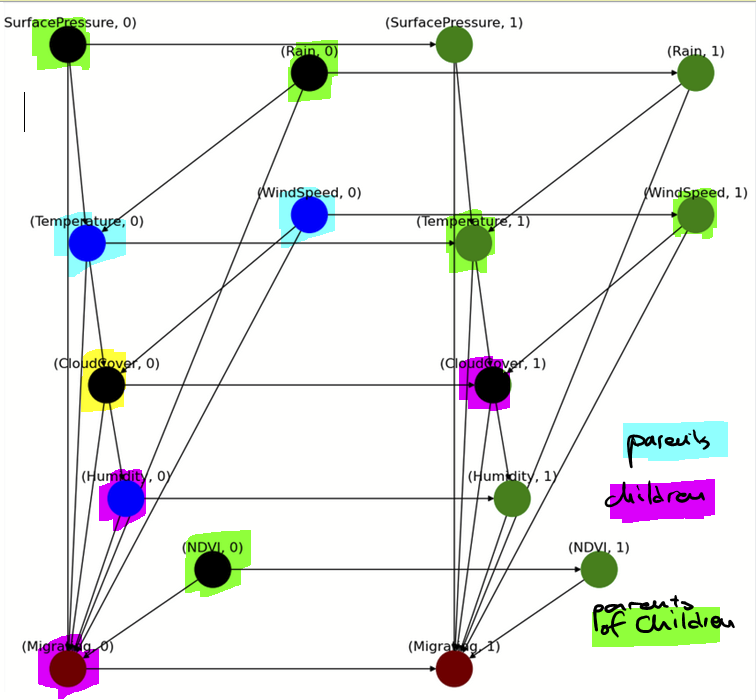

#### 🔺Simulating new data records

In [16]:
simulated_df = dbn.simulate(int(1e4))
display(simulated_df.head())

  0%|          | 0/16 [00:00<?, ?it/s]

,"(SurfacePressure, 0)","(Temperature, 0)","(Migrating, 0)","(SurfacePressure, 1)","(CloudCover, 0)","(Temperature, 1)","(Migrating, 1)","(CloudCover, 1)","(Rain, 0)","(Rain, 1)","(Humidity, 0)","(Humidity, 1)","(WindSpeed, 0)","(WindSpeed, 1)","(NDVI, 0)","(NDVI, 1)"
0,0,2,1,0,0,2,0,0,0,1,0,0,1,1,0,0
1,1,1,1,0,1,1,1,0,1,0,1,0,0,0,0,1
2,1,0,0,1,0,1,0,0,1,1,0,1,1,0,1,1
3,1,1,0,0,0,1,0,0,0,1,1,0,1,1,1,1
4,0,0,1,0,0,2,1,1,0,0,0,1,1,0,0,0


#### 🔺Querying Dynamic Bayesian Network

In [17]:
inference = DBNInference(dbn)
query_variable = 'Migrating'
evidence = {}  # Provide evidence variable 'A' at time slice 0
evidence = {("CloudCover", 0):1 ,("Temperature", 1):2}  # Provide evidence variable 'A' at time slice 0
print(inference.forward_inference([('Migrating',1)],evidence)[('Migrating',1)])

+---------------------+-------------------------+
| ('Migrating', 1)    |   phi(('Migrating', 1)) |
+=====================+=========================+
| ('Migrating', 1)(0) |                  0.5094 |
+---------------------+-------------------------+
| ('Migrating', 1)(1) |                  0.4906 |
+---------------------+-------------------------+


### 🔹Conclusion

The aim of this study was to develop a Dynamic Bayesian Network to understand the migration patterns of the white stork, leveraging climate and vegetation indicators to uncover the underlying relationships. The model was constructed using the pgmpy library in Python, fitting it with time-series data gathered from various sources after integration and preprocessing. The fundamental concepts were explored, including Markov blanket, Independence, Sampling, and Inference within the context of the DBN, along with calculated Conditional Probability Distributions (CPDs). Despite these efforts, the analysis yielded unsatisfactory results, with DiscretizedFactors hovering around 0.5, akin to random classification. This suggests limited predictive capability and a lack of explanatory power within the DBN. To address these shortcomings, further investigation, model evaluation, and refinement are imperative to enhance predictive performance and capture meaningful relationships in the data.